<a href="https://colab.research.google.com/github/fan-of-dark/UNET_Segmentation/blob/main/Brain_Tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Connecting Gdrive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount= True)

Mounted at /content/gdrive/


Importing Necessary Libraries

In [2]:
#Notebook
import os
import json
from zipfile import ZipFile
import shutil
from glob import glob
from tqdm import tqdm

#Data
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("dark_background")

#Image
import cv2 as cv
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

#keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential,load_model
from keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda
from keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, AveragePooling2D
from keras.layers import concatenate, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from keras.metrics import accuracy, binary_crossentropy
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from keras import backend as K

If GPU ready or not

In [3]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-608b5aeb-f9e3-765c-6af7-c316c065ce16)


Importing Data

In [12]:
# %cp -av "/content/gdrive/MyDrive/ECE_MINI_PROJECT/Brain_Tumor/data/" "/content/data" 

This taking so much time so importing directly from kaggle

In [4]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp /content/gdrive/MyDrive/kaggle.json ~/.kaggle/

token = {"username":"saivikassingamsetty","key":"a978868bd2c5887a3ac9e0c6162fe2fe"}

with open("/root/.kaggle/kaggle.json", "w") as file:
  json.dump(token,file)

!chmod 600 /root/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

 99% 709M/714M [00:06<00:00, 110MB/s] 
100% 714M/714M [00:06<00:00, 110MB/s]


In [6]:
with ZipFile("/content/lgg-mri-segmentation.zip", "r") as f:
  f.extractall()
shutil.rmtree("/content/lgg-mri-segmentation")
os.rename("/content/kaggle_3m", "/content/dataset")

In [7]:
!rm /content/lgg-mri-segmentation.zip

Making folders

In [8]:
IMG_SIZE = (256,256)

In [9]:
train_files = []
mask_files = glob("/content/dataset/*/*_mask*")

for f in tqdm(mask_files):
  train_files.append(f.replace('_mask', ''))

100%|██████████| 3929/3929 [00:00<00:00, 396235.16it/s]


Plotting 10 random images with masks

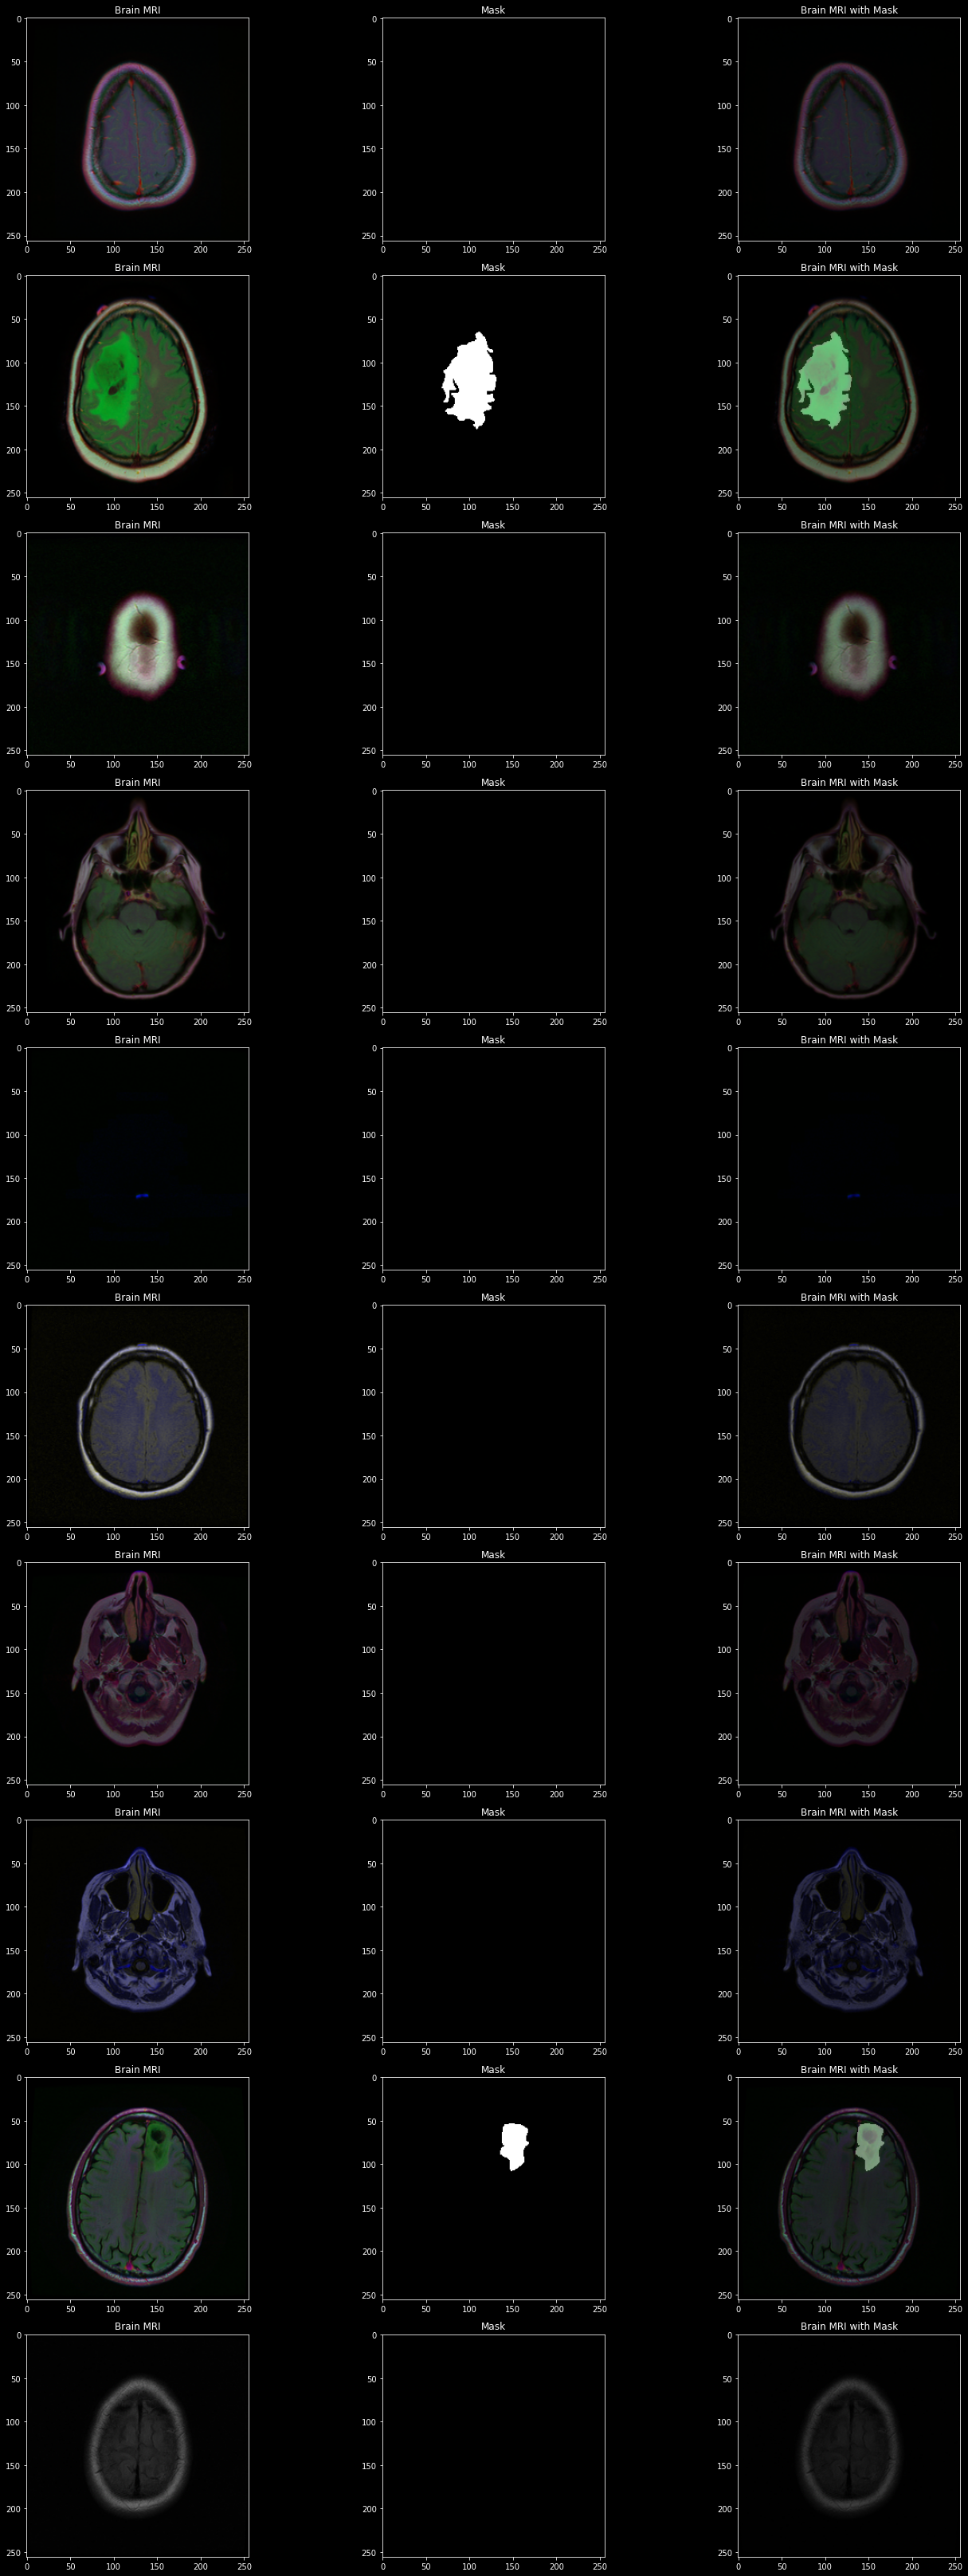

In [10]:
fig, ax = plt.subplots(10,3,figsize=(20,45))
for x in range(10):
  ind = random.randint(0,len(train_files))
  img = cv.imread(train_files[ind])
  mask = cv.imread(mask_files[ind])

  ax[x][0].title.set_text("Brain MRI")
  ax[x][0].imshow(img)

  ax[x][1].title.set_text("Mask")
  ax[x][1].imshow(mask)
  
  ax[x][2].title.set_text("Brain MRI with Mask")
  ax[x][2].imshow(img)
  ax[x][2].imshow(mask, alpha=0.4)
plt.tight_layout()

Making Train and valid dataframes



In [11]:
df = pd.DataFrame({"image_path": train_files, "mask_path":mask_files})

In [12]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.15, shuffle = True)
df_train, df_val = train_test_split(df_train, test_size=0.15, shuffle = True)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2838, 2)
(501, 2)
(590, 2)


Data Generation for Model


1.   Data generator - train, test generators
2.   Data Augmentation
3.   Data Adjustment



In [14]:
def adjust_data(img,mask):
    img = img / 255.
    mask = mask / 255.
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

Data Augmentor dict for train_generator

In [16]:
train_gen_aug = dict(rotation_range=0.2,
                        width_shift_range=0.05,
                        height_shift_range=0.05,
                        shear_range=0.05,
                        zoom_range=0.05,
                        horizontal_flip=True,
                        fill_mode='nearest')

In [17]:
def train_generator(dataframe, batch_size, aug_dict, 
                    image_color_mode = "rgb",
                    mask_color_mode = "grayscale",
                    image_save_prefix = "image",
                    mask_save_prefix = "mask",
                    save_to_dir = None,
                    target_size = (256,256),
                    seed = 1):
  
  #Initialising Data generators with augmentation dict
  image_datagen = ImageDataGenerator(**aug_dict)
  mask_datagen = ImageDataGenerator(**aug_dict)

  #image
  image_generator = image_datagen.flow_from_dataframe(
      dataframe,
      x_col = "image_path",
      target_size = target_size,
      batch_size = batch_size,
      class_mode = None,
      color_mode = image_color_mode,
      save_to_dir = save_to_dir,
      save_prefix = image_save_prefix,
      seed = seed )

  #mask
  mask_generator = mask_datagen.flow_from_dataframe(
      dataframe,
      x_col = "mask_path",
      target_size = target_size,
      batch_size = batch_size,
      class_mode = None,
      color_mode = mask_color_mode,
      save_to_dir = save_to_dir,
      save_prefix = mask_save_prefix,
      seed = seed)
  
  #combining the generators to make a whole generator
  train_gen = zip(image_generator, mask_generator)

  #data adjustment
  for (img, mask) in train_gen:
    img, mask = adjust_data(img, mask)
    yield (img,mask)

Unet Model

In [18]:
def DoubleConv(inp, filters, dropout):
  #A 3X3 2D conv-dropout-conv trio
  layer1 = Conv2D(filters = filters, kernel_size = (3,3), activation= "relu", kernel_initializer= "he_normal", padding = "same")(inp)
  layer2 = Dropout(rate = dropout)(layer1)
  layer3 = Conv2D(filters= filters, kernel_size= (3,3), activation= "relu", kernel_initializer= "he_normal", padding = "same")(layer2)
  out = BatchNormalization(axis = 3)(layer3)
  return out

In [19]:
def unet(input_size = (256,256,3)):
  #Input Layer
  inputs = Input(input_size)

  #Encoder network
  conv1 = DoubleConv(inputs,64,0.1)
  pool1 = MaxPooling2D(pool_size= (2,2))(conv1)

  conv2 = DoubleConv(pool1,128,0.1)
  pool2 = MaxPooling2D(pool_size= (2,2))(conv2)

  conv3 = DoubleConv(pool2,256,0.1)
  pool3 = MaxPooling2D(pool_size= (2,2))(conv3)

  conv4 = DoubleConv(pool3,512,0.1)
  pool4 = MaxPooling2D(pool_size= (2,2))(conv4)

  conv5 = DoubleConv(pool4,1024,0.1)

  #decoder network
  up6 = Conv2DTranspose(512, (2,2), strides = (2,2), padding = "same")(conv5)
  up6 = concatenate([up6, conv4], axis = 3)
  conv6 = DoubleConv(up6, 512, 0.1)

  up7 = Conv2DTranspose(256, (2,2), strides = (2,2), padding = "same")(conv6)
  up7 = concatenate([up7, conv3], axis = 3)
  conv7 = DoubleConv(up7, 256, 0.1)

  up8 = Conv2DTranspose(128, (2,2), strides = (2,2), padding = "same")(conv7)
  up8 = concatenate([up8, conv2], axis = 3)
  conv8 = DoubleConv(up8, 128, 0.1)

  up9 = Conv2DTranspose(64, (2,2), strides = (2,2), padding = "same")(conv8)
  up9 = concatenate([up9, conv1], axis = 3)
  conv9 = DoubleConv(up9, 64, 0.1)

  #output layer
  conv10 = Conv2D(1, (1,1), activation= "sigmoid")(conv9)

  model = Model(inputs = [inputs], outputs = [conv10])

  return model

In [39]:
BATCH_SIZE = 8

In [40]:
train_gen = train_generator(df_train, batch_size= BATCH_SIZE, 
                            aug_dict = train_gen_aug,
                            target_size = IMG_SIZE)
test_gen = train_generator(df_val, batch_size = BATCH_SIZE,
                           aug_dict = dict(),
                           target_size = IMG_SIZE)
model = unet((IMG_SIZE[0], IMG_SIZE[1], 3))

Metrics and Loss

In [41]:
EPOCHS = 150
BATCH_SIZE = 8
learning_rate = 1e-4

In [42]:
#METRIC
smooth=100

def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)
  
#OPTIMIZER
decay_rate = learning_rate / EPOCHS
opt = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)

In [43]:
model.compile(optimizer=opt, loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])

In [44]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 256, 256, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 256, 256, 64) 0           conv2d_19[0][0]                  
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 64) 36928       dropout_9[0][0]                  
____________________________________________________________________________________________

Callbacks

In [45]:
check_pointer = ModelCheckpoint('unet_seg.h5', verbose=1, save_best_only=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_dice_coef',
                                            patience=10,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.0000001)
early_stopper = EarlyStopping(patience = 5, verbose = 1)

Training

In [ ]:
model.fit(train_gen,
          steps_per_epoch = len(df_train)/BATCH_SIZE,
          epochs = EPOCHS,
          callbacks = [check_pointer, learning_rate_reduction, early_stopper],
          validation_data = test_gen,
          validation_steps= len(df_val)/ BATCH_SIZE) 

Found 2838 validated image filenames.
Found 2838 validated image filenames.
Epoch 1/150
355/354 [==============================] - ETA: 0s - loss: -10.4229 - binary_accuracy: 0.8676 - iou: 0.0579 - dice_coef: 10.4302Found 501 validated image filenames.
Found 501 validated image filenames.
354/354 [==============================] - 441s 1s/step - loss: -10.4229 - binary_accuracy: 0.8676 - iou: 0.0579 - dice_coef: 10.4302 - val_loss: -38.8646 - val_binary_accuracy: 0.9855 - val_iou: 0.2900 - val_dice_coef: 38.6332

Epoch 00001: val_loss improved from inf to -38.86458, saving model to unet_seg.h5
Epoch 2/150
355/354 [==============================] - ETA: 0s - loss: -17.8075 - binary_accuracy: 0.9389 - iou: 0.1048 - dice_coef: 17.8091